---
title: NerFs for SSH
date: 2023-08-09
subject: Neural Fields for SSH Interpolation
subtitle: Naive Nerfs applied to SSH Data
short_title: Spatiotemporal Data
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - CNRS
      - MEOM
    orcid: 0000-0002-6739-0053
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: data-assimilation, open-science
abbreviations:
    NerF: Neural Field
---

In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"

import autoroot
import typing as tp
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jrandom
import numpy as np
import pandas as pd
import keras_core as keras
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from omegaconf import OmegaConf
import hydra
from sklearn.pipeline import Pipeline


sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", False)

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using JAX backend.


## Recap Formulation

We are interested in learning non-linear functions $\boldsymbol{f}$.

$$
\begin{aligned}
\boldsymbol{f}(\mathbf{x}) &=
\mathbf{w}^\top\boldsymbol{\phi}(\mathbf{x})+\mathbf{b}
\end{aligned}
$$

where the $\boldsymbol{\phi}(\cdot)$ is a basis function. Neural Fields typically try to learn this basis funciton via a series of composite functions of the form

$$
\boldsymbol{\phi}(\mathbf{x}) =
\boldsymbol{\phi}_L\circ\boldsymbol{\phi}_{L-1}
\circ\cdots\circ
\boldsymbol{\phi}_2\circ\boldsymbol{\phi}_{1}(\mathbf{x})
$$

## Problems

Here, we will demonstrate a very simple spatial interpolation problem for sea surface height.

## Data

In [4]:
!ls /Volumes/EMANS_HDD/data/oceanbench-data-registry/osse_natl60/coord/nadirs

en.nc       g2.nc       j1.nc       swot.nc     tpn.nc
en.nc.dvc   g2.nc.dvc   j1.nc.dvc   swot.nc.dvc tpn.nc.dvc


In [96]:
import xarray as xr
from oceanbench._src.geoprocessing.temporal import time_rescale


xrds = xr.open_dataset("/Volumes/EMANS_HDD/data/oceanbench-data-registry/osse_natl60/grid/gf_obs_nadir.nc")
xrds = xrds.sel(time=slice("2012-10-01","2012-12-02"))
xrds_true = xr.open_dataset("/Volumes/EMANS_HDD/data/oceanbench-data-registry/osse_natl60/grid/gf_mod_ssh_daily.nc")
xrds_true = xrds_true.sel(time=slice("2012-10-01","2012-12-02"))
xrds["ssh"] = (("time", "lat", "lon"), xrds_true["ssh"].transpose("time", "lat", "lon").data)
#
xrds = time_rescale(xrds, freq_dt=1, freq_unit="seconds", t0=None)
xrds

<xarray.Dataset>
Dimensions:      (lat: 201, lon: 201, time: 63)
Coordinates:
  * lon          (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat          (lat) float64 33.0 33.05 33.1 33.15 ... 42.85 42.9 42.95 43.0
  * time         (time) float32 0.0 8.64e+04 1.728e+05 ... 5.27e+06 5.357e+06
Data variables:
    mask         (lat, lon) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    lag          (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    flag         (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    ssh_obs      (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    ssh_mod      (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    anomaly_obs  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    anomaly_mod  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    ssh          (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [97]:
xrds_true, xrds

(<xarray.Dataset>
 Dimensions:  (time: 63, lat: 201, lon: 201)
 Coordinates:
   * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
   * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
   * time     (time) datetime64[ns] 2012-10-01T12:00:00 ... 2012-12-02T12:00:00
 Data variables:
     ssh      (time, lat, lon) float64 ...,
 <xarray.Dataset>
 Dimensions:      (lat: 201, lon: 201, time: 63)
 Coordinates:
   * lon          (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
   * lat          (lat) float64 33.0 33.05 33.1 33.15 ... 42.85 42.9 42.95 43.0
   * time         (time) float32 0.0 8.64e+04 1.728e+05 ... 5.27e+06 5.357e+06
 Data variables:
     mask         (lat, lon) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
     lag          (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
     flag         (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
     ssh_obs      (time, lat, lon) float64 nan 

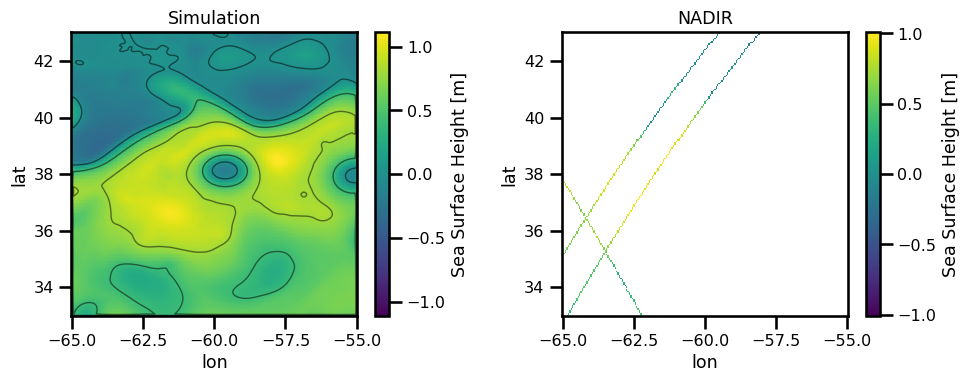

In [98]:
from matplotlib import ticker

variable = "ssh"
time = -6

fig, ax = plt.subplots(ncols=2, figsize=(10,4))

subset_ds = xrds.isel(time=time)

cbar_kwargs = {"label": "Sea Surface Height [m]"}
subset_ds["ssh"].plot.pcolormesh(ax=ax[0], cmap="viridis", cbar_kwargs=cbar_kwargs)

loc = ticker.MaxNLocator(5)
levels = loc.tick_values(xrds["ssh"].min().values, xrds["ssh"].max().values)
subset_ds["ssh"].plot.contour(
    ax=ax[0], 
    alpha=0.5, linewidths=1, cmap="black",
    levels=levels,
    linestyles=np.where(levels >= 0, "-", "--")
    # vmin=vmin, vmax=vmax,
    # **kwargs
)   
ax[0].set(title="Simulation")

cbar_kwargs = {"label": "Sea Surface Height [m]"}
subset_ds["ssh_obs"].plot.pcolormesh(ax=ax[1], cmap="viridis", cbar_kwargs=cbar_kwargs)


subset_ds["ssh_obs"].plot.contour(
    ax=ax[1], 
    alpha=0.5, linewidths=1, cmap="black",
    levels=levels,
    linestyles=np.where(levels >= 0, "-", "--")
    # vmin=vmin, vmax=vmax,
    # **kwargs
)   
ax[1].set(title="NADIR")

plt.tight_layout()
plt.show()

In [99]:
dfds = xrds[["ssh", "ssh_obs"]].to_dataframe().reset_index()
# apply coordinate transformation
dfds.describe()

,time,lat,lon,ssh,ssh_obs
count,2.545263e+06,2.545263e+06,2.545263e+06,2.545263e+06,36068.000000
mean,2.678400e+06,3.800000e+01,-6.000000e+01,4.224794e-01,0.427965
std,1.571119e+06,2.901150e+00,2.901150e+00,3.929870e-01,0.392914
min,0.000000e+00,3.300000e+01,-6.500000e+01,-4.421602e-01,-0.459900
25%,1.296000e+06,3.550000e+01,-6.250000e+01,0.000000e+00,0.004100
50%,2.678400e+06,3.800000e+01,-6.000000e+01,4.946982e-01,0.498100
75%,4.060800e+06,4.050000e+01,-5.750000e+01,7.569129e-01,0.757200
max,5.356800e+06,4.300000e+01,-5.500000e+01,1.198458e+00,1.194600


In [100]:
from nerf4ssh._src.transforms.scaling import MinMaxDF

scaler = MinMaxDF(columns=["lon", "lat", "time"])
scaler.fit(dfds)

train_dfds = dfds.dropna()

x = scaler.fit_transform(train_dfds).values
y = train_dfds[["ssh_obs"]].values

x_eval = scaler.transform(dfds).values



x.shape, y.shape

((36068, 3), (36068, 1))

## Model

The input data is a coordinate vector, $\mathbf{x}_\phi$, of the image coordinates.

$$
\mathbf{x}_\phi \in \mathbb{R}^{D_\phi}
$$

where $D_\phi = [\text{x}, \text{y}]$. So we are interested in learning a function, $\boldsymbol{f}$, such that we can input a coordinate vector and output a scaler/vector value of the pixel value.

$$
\mathbf{u} = \boldsymbol{f}(\mathbf{x}_\phi; \boldsymbol{\theta})
$$

### MLP Layer

$$
\mathbf{f}_\ell(\mathbf{x}) = \sigma\left(\mathbf{w}^{(\ell)}\mathbf{x} + \mathbf{b}^{(\ell)} \right)
$$

where $\sigma$ is the *ReLU* activation function.

$$
\sigma(\mathbf{x}) = \text{ReLU}(\mathbf{x})
$$

In [101]:
# xrda["ssh_pre"] = (("time", "lat", "lon"), dm.data_to_df(out).to_xarray().ssh.data)

In [102]:
from nerf4ssh._src.losses import psnr

In [103]:
input_shape = (3,)
model = keras.Sequential(
    [
        keras.layers.Input(shape=input_shape),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(1, activation=None),
    ]
)

In [104]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 128)               │        512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_15 (Dense)                │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_16 (Dense)                │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_17 (Dense)                │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_18 (Dense)                │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_19 (Dense)                │ (None, 1)                 │        129 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 66,689 (2.04 MB)

 Trainable params: 66,689 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [105]:

verbose = 0

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="./checkpoints/model_mlp_osse_nadir_at_epoch_{epoch}.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="loss", patience=20),
]

In [106]:
# model.save("saved_models/final_model_mlp_.keras", )
# model = keras.saving.load_model("saved_models/final_model_mlp.keras")

In [107]:
batch_size = 2048
epochs = 500
warmup_steps = 50
learning_rate = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-5, 
    decay_steps=epochs - warmup_steps, 
    alpha=0.1, 
    warmup_steps=warmup_steps,
    warmup_target=1e-3
)

In [108]:
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=[
        psnr,
    ]
)

In [137]:
x.shape

(36068, 3)

In [138]:
train_lengths = [
    1_000, 10_000, 20_000, 30_000, None, 
]

In [140]:
from tqdm.notebook import tqdm
for itrain in tqdm(train_lengths):
    history_mlp = model.fit(
        x=x[:itrain], y=y[:itrain],
        validation_split=0.1,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        verbose=0
    )

  0%|          | 0/5 [00:00<?, ?it/s]

In [141]:
model.save("saved_models/final_model_mlp_osse_nadir.keras")

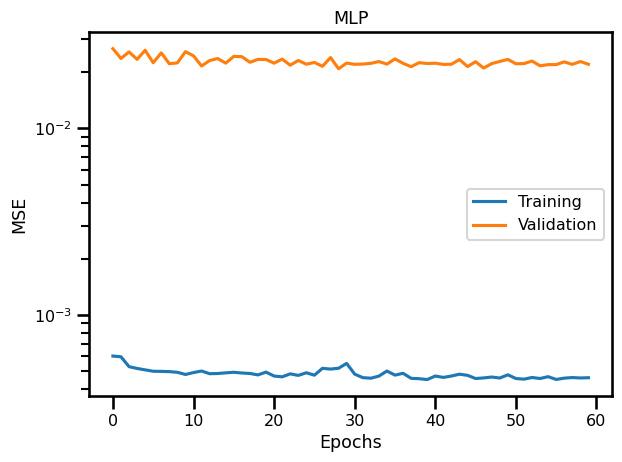

In [142]:
fig, ax = plt.subplots()

ax.plot(history_mlp.epoch, history_mlp.history['loss'], label="Training")
ax.plot(history_mlp.epoch, history_mlp.history['val_loss'], label="Validation")
ax.set(
    title="MLP",
    xlabel="Epochs", #xscale="log", 
    ylabel="MSE", yscale="log")
plt.legend()
plt.tight_layout()
plt.show()

In [143]:
score = model.evaluate(x=x, y=y, verbose=1)

1128/1128 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - loss: 5.5341e-04 - psnr: 39.2273


In [144]:
x_eval = scaler.transform(dfds).values

predictions = model.predict(x=x_eval)

79540/79540 ━━━━━━━━━━━━━━━━━━━━ 8s 100us/step


In [145]:
dfds["ssh_mlp"] = predictions

In [146]:
dfds.head()


,time,lat,lon,ssh,ssh_obs,ssh_mlp
0,0.0,33.0,-65.00,0.0,NaN,0.488358
1,0.0,33.0,-64.95,0.0,NaN,0.494576
2,0.0,33.0,-64.90,0.0,NaN,0.500145
3,0.0,33.0,-64.85,0.0,NaN,0.503982
4,0.0,33.0,-64.80,0.0,NaN,0.507404


In [147]:
meta_cols = ["time", "lat", "lon"]
var_cols = ["ssh", "ssh_obs", "ssh_mlp"]
xrds_ = dfds.reset_index().set_index(meta_cols)[var_cols].to_xarray()

xrds_

<xarray.Dataset>
Dimensions:  (time: 63, lat: 201, lon: 201)
Coordinates:
  * time     (time) float64 0.0 8.64e+04 1.728e+05 ... 5.27e+06 5.357e+06
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
Data variables:
    ssh      (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ssh_obs  (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    ssh_mlp  (time, lat, lon) float32 0.4884 0.4946 0.5001 ... -0.2405 -0.2495

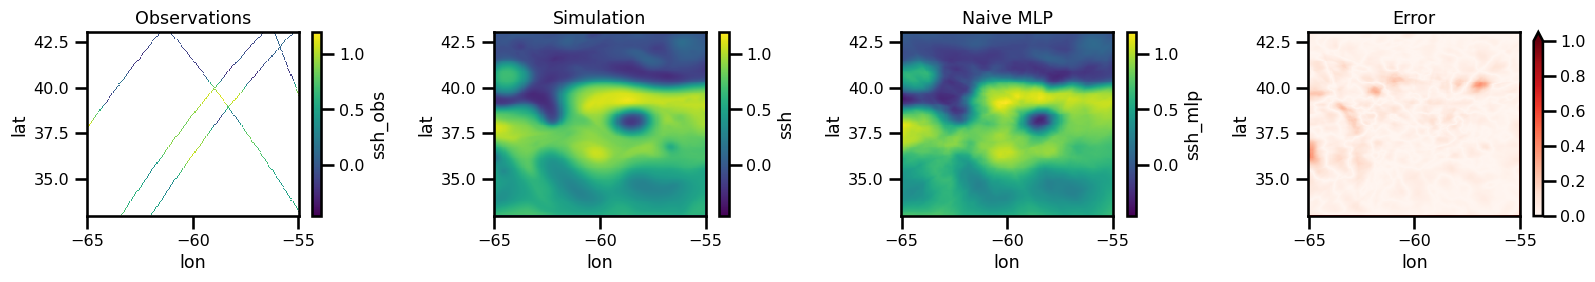

In [148]:
fig, ax = plt.subplots(ncols=4, figsize=(16, 3))

time = 20

vmin = xrds_.ssh_obs.min()
vmax = xrds_.ssh_obs.max()

xrds_.ssh_obs.isel(time=time).plot.pcolormesh(ax=ax[0], cmap="viridis", vmin=vmin, vmax=vmax)
ax[0].set(title="Observations")

xrds_.ssh.isel(time=time).plot.pcolormesh(ax=ax[1], cmap="viridis", vmin=vmin, vmax=vmax)
ax[1].set(title="Simulation")

xrds_.ssh_mlp.isel(time=time).plot.pcolormesh(ax=ax[2], cmap="viridis", vmin=vmin, vmax=vmax)
ax[2].set(title="Naive MLP")

np.abs(xrds_.ssh_mlp-xrds_.ssh).isel(time=time).plot.pcolormesh(ax=ax[3], cmap="Reds", vmin=0.0, vmax=1.0)
ax[3].set(title="Error")

plt.tight_layout()
plt.show()

### Random Fourier Features

In [149]:
from nerf4ssh._src.models.rff import RFFLayer

In [150]:
input_shape = (3,)
model_rff = keras.Sequential(
    [
        keras.layers.Input(shape=input_shape),
        RFFLayer(num_features=128),
        keras.layers.Dense(units=128, activation=None),
        RFFLayer(num_features=128),
        keras.layers.Dense(units=128, activation=None),
        RFFLayer(num_features=128),
        keras.layers.Dense(units=128, activation=None),
        RFFLayer(num_features=128),
        keras.layers.Dense(units=1),
    ]
)

In [151]:
model_rff.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ rff_layer_8 (RFFLayer)          │ (None, 256)               │        386 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_20 (Dense)                │ (None, 128)               │     32,896 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ rff_layer_9 (RFFLayer)          │ (None, 256)               │     16,386 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_21 (Dense)                │ (None, 128)               │     32,896 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ rff_layer_10 (RFFLayer)         │ (None, 256)               │     16,386 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_22 (Dense)                │ (None, 128)               │     32,896 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ rff_layer_11 (RFFLayer)         │ (None, 256)               │     16,386 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_23 (Dense)                │ (None, 1)                 │        257 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 148,489 (4.53 MB)

 Trainable params: 98,953 (3.02 MB)

 Non-trainable params: 49,536 (1.51 MB)

In [152]:

verbose = 0

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="./checkpoints/model_rff_spatiotemporal_at_epoch_{epoch}.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="loss", patience=50),
]

In [153]:
# model.save("saved_models/final_model_mlp_.keras", )
# model = keras.saving.load_model("saved_models/final_model_rff_osse_nadir.keras")

In [154]:
batch_size = 2048
epochs = 500
warmup_steps = 50
learning_rate = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-5, 
    decay_steps=epochs - warmup_steps, 
    alpha=0.1, 
    warmup_steps=warmup_steps,
    warmup_target=1e-3
)

In [155]:
model_rff.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=[
        psnr,
    ]
)

In [156]:
from tqdm.notebook import tqdm
for itrain in tqdm(train_lengths):
    history_rff = model_rff.fit(
        x=x[:itrain], y=y[:itrain],
        validation_split=0.1,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        verbose=0
    )

  0%|          | 0/5 [00:00<?, ?it/s]

In [157]:
model_rff.save("saved_models/final_model_rff_osse_nadir.keras")

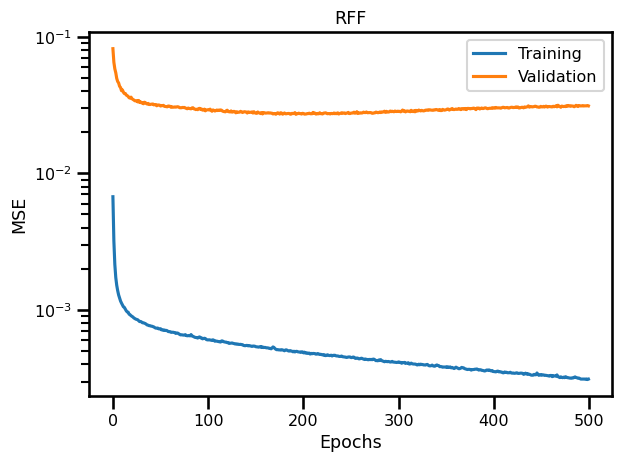

In [158]:
fig, ax = plt.subplots()

ax.plot(history_rff.epoch, history_rff.history['loss'], label="Training")
ax.plot(history_rff.epoch, history_rff.history['val_loss'], label="Validation")
ax.set(
    title="RFF",
    xlabel="Epochs", #xscale="log", 
    ylabel="MSE", yscale="log")
plt.legend()
plt.tight_layout()
plt.show()

In [159]:
score = model_rff.evaluate(x=x, y=y, verbose=1)

1128/1128 ━━━━━━━━━━━━━━━━━━━━ 1s 985us/step - loss: 3.8753e-04 - psnr: 41.6185


In [160]:

predictions = model_rff.predict(x=x_eval)

79540/79540 ━━━━━━━━━━━━━━━━━━━━ 29s 363us/step


In [161]:
dfds["ssh_rff"] = predictions

In [162]:
dfds.head()


,time,lat,lon,ssh,ssh_obs,ssh_mlp,ssh_rff
0,0.0,33.0,-65.00,0.0,NaN,0.488358,0.805140
1,0.0,33.0,-64.95,0.0,NaN,0.494576,0.795566
2,0.0,33.0,-64.90,0.0,NaN,0.500145,0.786316
3,0.0,33.0,-64.85,0.0,NaN,0.503982,0.777435
4,0.0,33.0,-64.80,0.0,NaN,0.507404,0.768951


In [163]:
meta_cols = ["time", "lat", "lon"]
var_cols = ["ssh", "ssh_obs", "ssh_mlp", "ssh_rff"]
xrds_ = dfds.reset_index().set_index(meta_cols)[var_cols].to_xarray()

xrds_

<xarray.Dataset>
Dimensions:  (time: 63, lat: 201, lon: 201)
Coordinates:
  * time     (time) float64 0.0 8.64e+04 1.728e+05 ... 5.27e+06 5.357e+06
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
Data variables:
    ssh      (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ssh_obs  (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    ssh_mlp  (time, lat, lon) float32 0.4884 0.4946 0.5001 ... -0.2405 -0.2495
    ssh_rff  (time, lat, lon) float32 0.8051 0.7956 0.7863 ... -0.1237 -0.1233

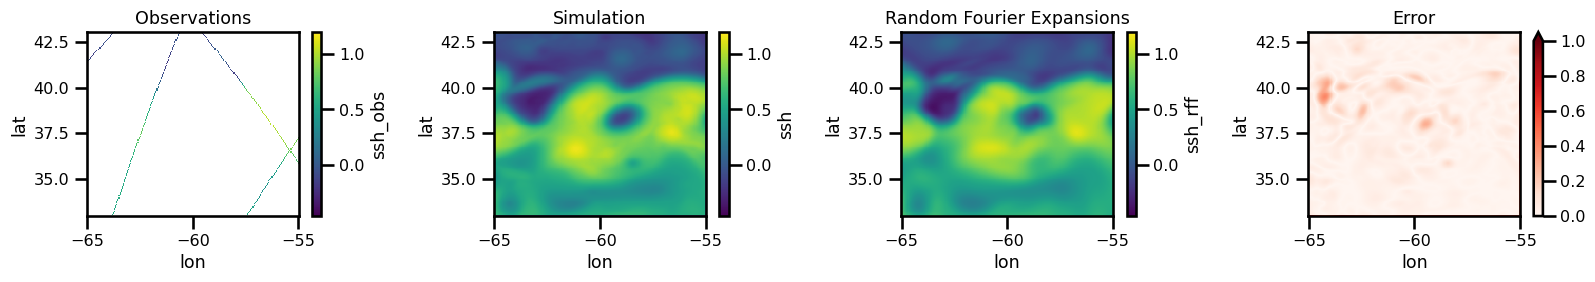

In [164]:
fig, ax = plt.subplots(ncols=4, figsize=(16, 3))

time = 41

vmin = xrds_.ssh_obs.min()
vmax = xrds_.ssh_obs.max()

xrds_.ssh_obs.isel(time=time).plot.pcolormesh(ax=ax[0], cmap="viridis", vmin=vmin, vmax=vmax)
ax[0].set(title="Observations")

xrds_.ssh.isel(time=time).plot.pcolormesh(ax=ax[1], cmap="viridis", vmin=vmin, vmax=vmax)
ax[1].set(title="Simulation")

xrds_.ssh_rff.isel(time=time).plot.pcolormesh(ax=ax[2], cmap="viridis", vmin=vmin, vmax=vmax)
ax[2].set(title="Random Fourier Expansions")

np.abs(xrds_.ssh_rff-xrds_.ssh).isel(time=time).plot.pcolormesh(ax=ax[3], cmap="Reds", vmin=0.0, vmax=1.0)
ax[3].set(title="Error")

plt.tight_layout()
plt.show()

### SIREN

In [165]:
from nerf4ssh._src.models.siren import SirenLayer

In [166]:
input_shape = (3,)
c = 6
omega_0 = 10
omega = 1.0
model_siren = keras.Sequential(
    [
        keras.layers.Input(shape=input_shape),
        SirenLayer(units=128, omega=omega_0, c=c, layer_type="first"),
        SirenLayer(units=128, omega=omega, c=c),
        SirenLayer(units=128, omega=omega, c=c),
        SirenLayer(units=128, omega=omega, c=c),
        SirenLayer(units=128, omega=omega, c=c),
        SirenLayer(units=1, omega=omega, c=c, layer_type="last"),
    ]
)

In [167]:
model_siren.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ siren_layer_6 (SirenLayer)      │ (None, 128)               │        512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ siren_layer_7 (SirenLayer)      │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ siren_layer_8 (SirenLayer)      │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ siren_layer_9 (SirenLayer)      │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ siren_layer_10 (SirenLayer)     │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ siren_layer_11 (SirenLayer)     │ (None, 1)                 │        129 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 66,689 (2.04 MB)

 Trainable params: 66,689 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [168]:
# model.save("saved_models/final_model_mlp_.keras", )
# model = keras.saving.load_model("saved_models/final_model_siren_osse_nadir.keras")

In [169]:
batch_size = 2048
epochs = 500
warmup_steps = 50
learning_rate = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-5, 
    decay_steps=epochs - warmup_steps, 
    alpha=0.1, 
    warmup_steps=warmup_steps,
    warmup_target=1e-3
)

In [170]:
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="./checkpoints/model_siren_spatiotemporal_at_epoch_{epoch}.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="loss", patience=50),
]

In [171]:
model_siren.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=[
        psnr,
    ]
)

In [172]:
from tqdm.notebook import tqdm
for itrain in tqdm(train_lengths):
    history_siren = model_siren.fit(
        x=x[:itrain], y=y[:itrain],
        validation_split=0.1,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        verbose=0
    )

  0%|          | 0/5 [00:00<?, ?it/s]

In [173]:
# history_siren = model_siren.fit(
#     x=x, y=y,
#     validation_split=0.1,
#     batch_size=batch_size,
#     epochs=epochs,
#     callbacks=callbacks,
#     verbose=1
# )

In [174]:
model_siren.save("saved_models/final_model_siren_osse_nadir.keras")

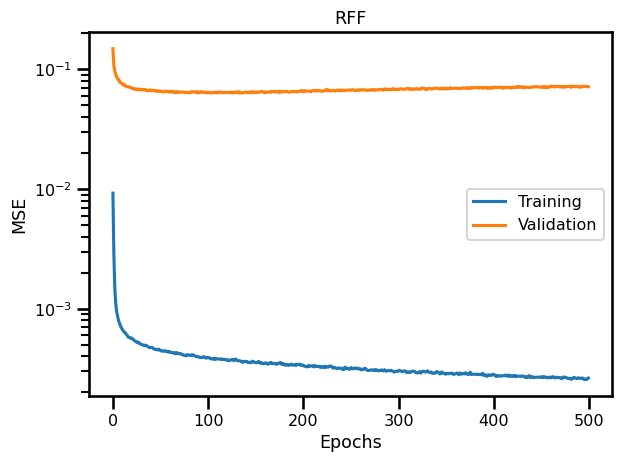

In [175]:
fig, ax = plt.subplots()

ax.plot(history_siren.epoch, history_siren.history['loss'], label="Training")
ax.plot(history_siren.epoch, history_siren.history['val_loss'], label="Validation")
ax.set(
    title="RFF",
    xlabel="Epochs", #xscale="log", 
    ylabel="MSE", yscale="log")
plt.legend()
plt.tight_layout()
plt.show()

In [176]:
score = model_siren.evaluate(x=x, y=y, verbose=1)

1128/1128 ━━━━━━━━━━━━━━━━━━━━ 1s 682us/step - loss: 5.3873e-04 - psnr: 42.1350


In [177]:
predictions = model_siren.predict(x=x_eval)

79540/79540 ━━━━━━━━━━━━━━━━━━━━ 16s 200us/step


In [178]:
dfds["ssh_siren"] = predictions

In [179]:
dfds.head()


,time,lat,lon,ssh,ssh_obs,ssh_mlp,ssh_rff,ssh_siren
0,0.0,33.0,-65.00,0.0,NaN,0.488358,0.805140,0.377960
1,0.0,33.0,-64.95,0.0,NaN,0.494576,0.795566,0.376511
2,0.0,33.0,-64.90,0.0,NaN,0.500145,0.786316,0.377142
3,0.0,33.0,-64.85,0.0,NaN,0.503982,0.777435,0.379978
4,0.0,33.0,-64.80,0.0,NaN,0.507404,0.768951,0.385094


In [180]:
meta_cols = ["time", "lat", "lon"]
var_cols = ["ssh", "ssh_obs", "ssh_mlp", "ssh_rff", "ssh_siren"]
xrds_ = dfds.reset_index().set_index(meta_cols)[var_cols].to_xarray()

xrds_

<xarray.Dataset>
Dimensions:    (time: 63, lat: 201, lon: 201)
Coordinates:
  * time       (time) float64 0.0 8.64e+04 1.728e+05 ... 5.27e+06 5.357e+06
  * lat        (lat) float64 33.0 33.05 33.1 33.15 ... 42.85 42.9 42.95 43.0
  * lon        (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
Data variables:
    ssh        (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ssh_obs    (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    ssh_mlp    (time, lat, lon) float32 0.4884 0.4946 0.5001 ... -0.2405 -0.2495
    ssh_rff    (time, lat, lon) float32 0.8051 0.7956 0.7863 ... -0.1237 -0.1233
    ssh_siren  (time, lat, lon) float32 0.378 0.3765 0.3771 ... -0.3229 -0.3095

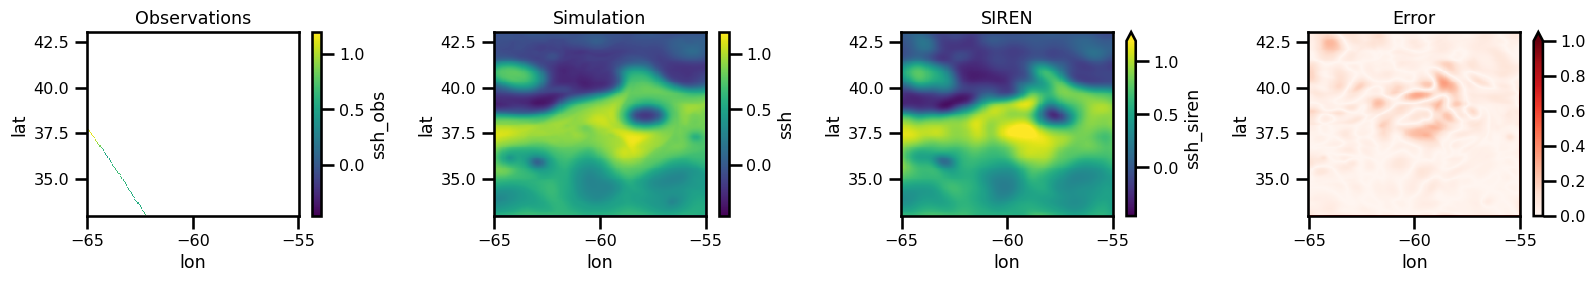

In [188]:
fig, ax = plt.subplots(ncols=4, figsize=(16, 3))

time = 5

vmin = xrds_.ssh_obs.min()
vmax = xrds_.ssh_obs.max()

xrds_.ssh_obs.isel(time=time).plot.pcolormesh(ax=ax[0], cmap="viridis", vmin=vmin, vmax=vmax)
ax[0].set(title="Observations")

xrds_.ssh.isel(time=time).plot.pcolormesh(ax=ax[1], cmap="viridis", vmin=vmin, vmax=vmax)
ax[1].set(title="Simulation")

xrds_.ssh_siren.isel(time=time).plot.pcolormesh(ax=ax[2], cmap="viridis", vmin=vmin, vmax=vmax)
ax[2].set(title="SIREN")

np.abs(xrds_.ssh_siren-xrds_.ssh).isel(time=time).plot.pcolormesh(ax=ax[3], cmap="Reds", vmin=0.0, vmax=1.0)
ax[3].set(title="Error")

plt.tight_layout()
plt.show()